In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from scipy.stats import randint
from sklearn.model_selection import cross_val_score
from sklearn.inspection import permutation_importance

In [2]:
#load your dataset
data = pd.read_csv('datasetbcfinalmiss_modified.csv') 

In [3]:
#exploratory data analysis 
print(data.head())
print(data.info())

   Last Price  Open Price     Max     Min  Size  Change Persent Class
0      3597.2      3785.7  4070.5  3561.3  3.80          0.0497   XRP
1      3677.8      3597.3  3715.2  3473.2  3.50          0.0224   XRP
2      3570.9      3676.2  3699.1  3465.2  3.16          0.0291   XRP
3      3502.5      3570.9  3583.2  3368.2  3.68          0.0192   XRP
4      3661.4      3502.3  3721.1  3382.5  3.78          0.0454   XRP
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2740 entries, 0 to 2739
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Last Price      2698 non-null   float64
 1   Open Price      2740 non-null   float64
 2   Max             2740 non-null   float64
 3   Min             2740 non-null   float64
 4   Size            2738 non-null   float64
 5   Change Persent  2740 non-null   float64
 6   Class           2740 non-null   object 
dtypes: float64(6), object(1)
memory usage: 150.0+ KB
None


In [4]:
# Handle missing values
# Fill missing values with forward fill for Last Price and mean for Size
data['Last Price'] = data['Last Price'].ffill()
data['Size'] = data['Size'].fillna(data['Size'].mean())

In [5]:
# Feature Engineering
# Create additional features like High-Low difference and Change Percent scaled
data['High_Low_Diff'] = data['Max'] - data['Min']
data['Change_Pct_Scaled'] = data['Change Persent'] * 100

In [6]:
# Define features (X) and target (y)
X = data[['Open Price', 'Max', 'Min', 'Size', 'High_Low_Diff', 'Change_Pct_Scaled']]
y = data['Last Price']

In [7]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

In [8]:
# Data Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [9]:
# Model Training with XGBoost
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)

In [10]:
# Hyperparameter tuning using GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 0.9, 1.0]
}
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, scoring='r2', verbose=1)
grid_search.fit(X_train_scaled, y_train)

Fitting 3 folds for each of 81 candidates, totalling 243 fits


GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=42, ...),
             param_grid={'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [100, 200, 300],
                         'subsample': [0.8, 0.9, 1.0]},
             scoring='r2', verbose=1)

In [11]:
# Best Model
best_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 300, 'subsample': 0.9}


In [12]:
# Model Evaluation
y_pred = best_model.predict(X_test_scaled)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"RMSE: {rmse}")
print(f"R2 Score: {r2}")

RMSE: 2.4273288363196466
R2 Score: 0.9767687055126792


In [13]:
# Initialize the model
linear_reg_model = LinearRegression()

# Train the model
linear_reg_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred_lr = linear_reg_model.predict(X_test_scaled)

# Evaluate the model
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2_lr = r2_score(y_test, y_pred_lr)

print(f"Linear Regression RMSE: {rmse_lr}")
print(f"Linear Regression R2 Score: {r2_lr}")

Linear Regression RMSE: 18.332638147990487
Linear Regression R2 Score: -0.3251532690351835


In [14]:
# Initialize the model
rf_model = RandomForestRegressor(n_estimators=2,random_state=42)

# Train the model
rf_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred_rf = rf_model.predict(X_test_scaled)

# Evaluate the model
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest RMSE: {rmse_rf}")
print(f"Random Forest R2 Score: {r2_rf}")

Random Forest RMSE: 3.742704733136344
Random Forest R2 Score: 0.9447684396902722


In [15]:
# Initialize the model
svr_model = SVR(kernel='rbf')

# Train the model
svr_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred_svr = svr_model.predict(X_test_scaled)

# Evaluate the model
rmse_svr = np.sqrt(mean_squared_error(y_test, y_pred_svr))
r2_svr = r2_score(y_test, y_pred_svr)

print(f"Support Vector Regression RMSE: {rmse_svr}")
print(f"Support Vector Regression R2 Score: {r2_svr}")

Support Vector Regression RMSE: 22.321110119769255
Support Vector Regression R2 Score: -0.9644806690928032


In [16]:
# Collect RMSE and R2 scores for each model
models = ['XGBoost', 'Linear Regression', 'Random Forest regressor', 'SVR']
rmse_scores = [rmse, rmse_lr, rmse_rf, rmse_svr]
r2_scores = [r2, r2_lr, r2_rf, r2_svr]
# Create a DataFrame for easy comparison
comparison_df = pd.DataFrame({
    'Model': models,
    'RMSE': rmse_scores,
    'R2 Score': r2_scores
})
print(comparison_df)

                     Model       RMSE  R2 Score
0                  XGBoost   2.427329  0.976769
1        Linear Regression  18.332638 -0.325153
2  Random Forest regressor   3.742705  0.944768
3                      SVR  22.321110 -0.964481


In [17]:
# Define hyperparameters for tuned Random Forest regressor
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

In [21]:
# Grid search for Random Forest regressor
grid_search_rf = GridSearchCV(estimator=RandomForestRegressor(random_state=42), 
                              param_grid=param_grid_rf, 
                              cv=5, 
                              scoring='neg_mean_squared_error', 
                              verbose=1)
grid_search_rf.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid={'max_depth': [10, 20, 30],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='neg_mean_squared_error', verbose=1)

In [22]:
# Best model and parameters tuned random forest
print("Best parameters for Random Forest:", grid_search_rf.best_params_)
# Make predictions with the best model
y_pred_rf_tuned = grid_search_rf.best_estimator_.predict(X_test_scaled)
# Evaluate the tuned model
rmse_rf_tuned = np.sqrt(mean_squared_error(y_test, y_pred_rf_tuned))
r2_rf_tuned = r2_score(y_test, y_pred_rf_tuned)
print(f"Tuned Random Forest RMSE: {rmse_rf_tuned}")
print(f"Tuned Random Forest R2 Score: {r2_rf_tuned}")

Best parameters for Random Forest: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 200}
Tuned Random Forest RMSE: 2.169833373147745
Tuned Random Forest R2 Score: 0.9814361116086996


In [23]:
# Define hyperparameters for Random Forest regressor
param_dist_rf = {
    'n_estimators': randint(100, 500),
    'max_depth': randint(10, 30),
    'min_samples_split': randint(2, 10)
}
# Randomized search for Random Forest
random_search_rf = RandomizedSearchCV(estimator=RandomForestRegressor(random_state=42), 
                                      param_distributions=param_dist_rf, 
                                      n_iter=50, 
                                      cv=5, 
                                      scoring='neg_mean_squared_error', 
                                      random_state=42, 
                                      verbose=1)
random_search_rf.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   n_iter=50,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001BDAB7C8200>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001BDAB609520>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001BDAB7ECAD0>},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=1)

In [24]:
# Best model and parameters
print("Best parameters for Random Forest:", random_search_rf.best_params_)
# Make predictions with the best model
y_pred_rf_random = random_search_rf.best_estimator_.predict(X_test_scaled)

Best parameters for Random Forest: {'max_depth': 16, 'min_samples_split': 2, 'n_estimators': 151}


In [25]:
# Get feature importances
feature_importances_xgb = best_model.feature_importances_

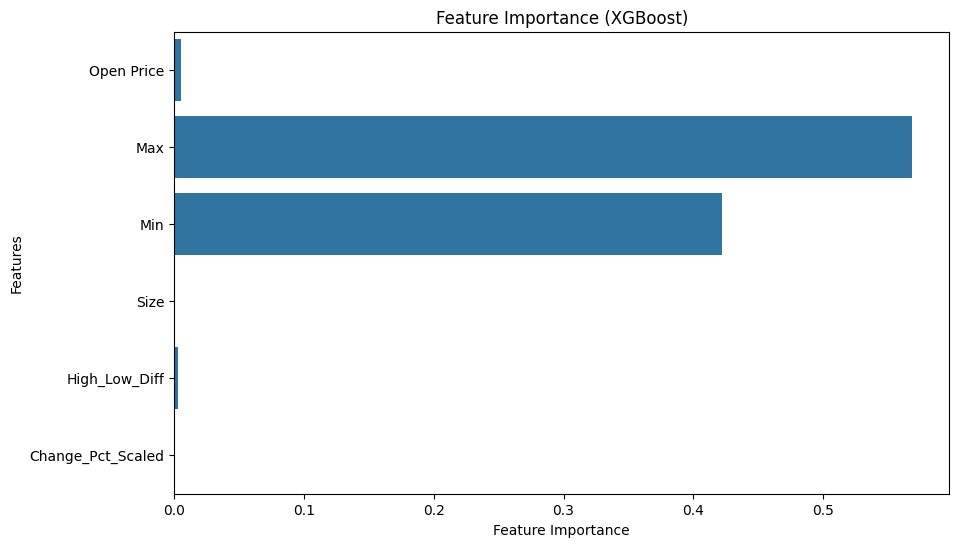

In [26]:
# Visualize feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances_xgb, y=X.columns)
plt.title("Feature Importance (XGBoost)")
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.show()

In [27]:
# Random Forest regressor model
rf_model.fit(X_train_scaled, y_train)

RandomForestRegressor(n_estimators=2, random_state=42)

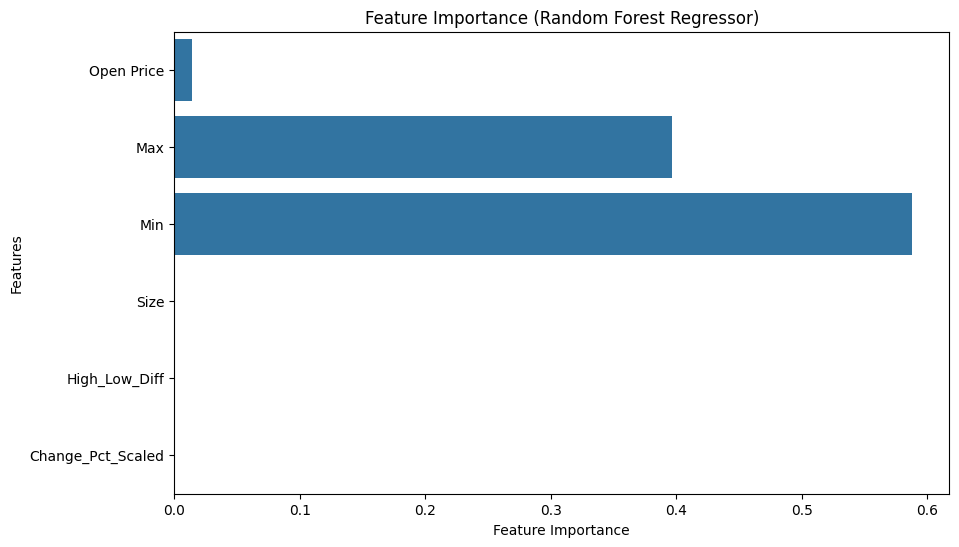

In [28]:
# Train the Random Forest Regressor model
rf_regressor = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
rf_regressor.fit(X_train, y_train)

# Get feature importances
feature_importances_rf = rf_regressor.feature_importances_

# Visualize feature importances for Random Forest Regressor
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances_rf, y=X.columns)
plt.title("Feature Importance (Random Forest Regressor)")
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.show()

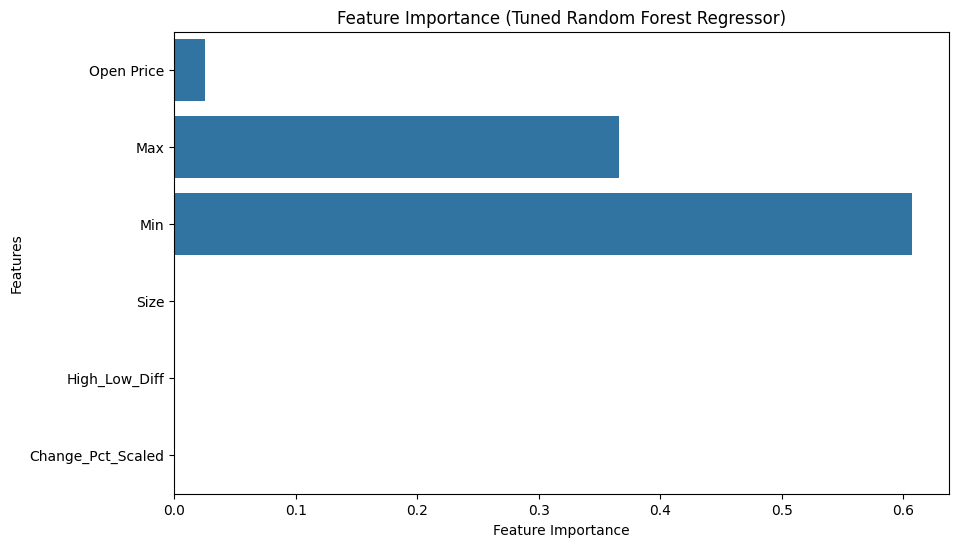

In [29]:
# Train the Tuned Random Forest Regressor model
tuned_rf_regressor = RandomForestRegressor(
    n_estimators=200,  # Example of tuned hyperparameter
    max_depth=15,      # Example of tuned hyperparameter
    min_samples_split=5,  # Example of tuned hyperparameter
    min_samples_leaf=2,   # Example of tuned hyperparameter
    random_state=42
)
tuned_rf_regressor.fit(X_train, y_train)

# Get feature importances
feature_importances_tuned_rf = tuned_rf_regressor.feature_importances_

# Visualize feature importances for Tuned Random Forest Regressor
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances_tuned_rf, y=X.columns)
plt.title("Feature Importance (Tuned Random Forest Regressor)")
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.show()

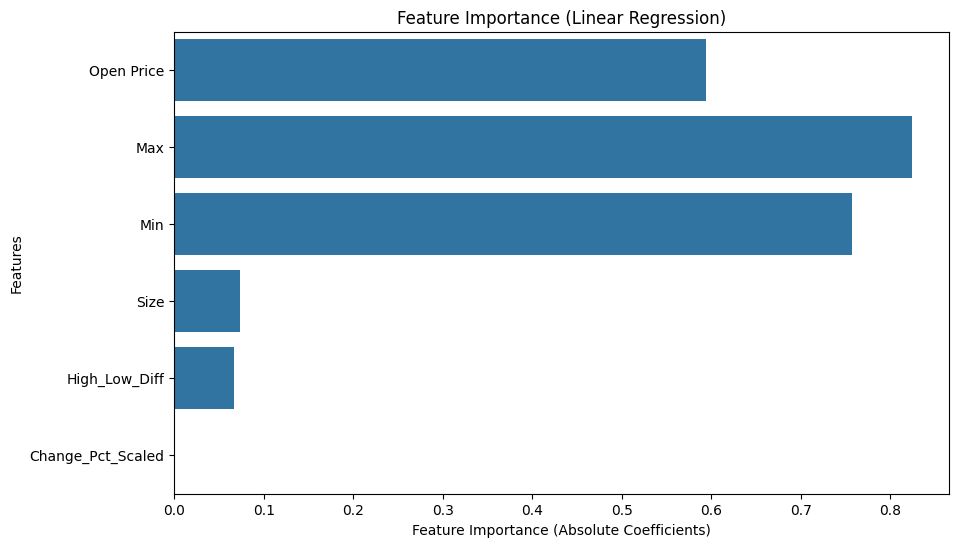

In [30]:
# Train the Linear Regression model
linear_regressor = LinearRegression()
linear_regressor.fit(X_train, y_train)

# Get absolute coefficients as feature importances
feature_importances_linear = np.abs(linear_regressor.coef_)

# Visualize feature importances for Linear Regression
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances_linear, y=X.columns)
plt.title("Feature Importance (Linear Regression)")
plt.xlabel("Feature Importance (Absolute Coefficients)")
plt.ylabel("Features")
plt.show()

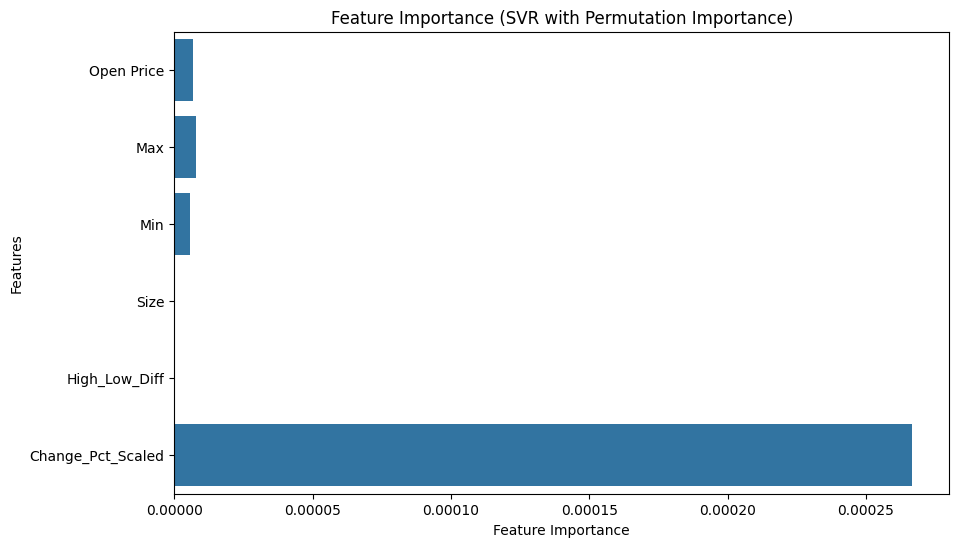

In [31]:
# Train the Support Vector Regressor model
svr_regressor = SVR(kernel='rbf', C=1.0, epsilon=0.1)
svr_regressor.fit(X_train, y_train)

# Calculate permutation importance
perm_importance = permutation_importance(svr_regressor, X_train, y_train, n_repeats=30, random_state=42)
feature_importances_svr = perm_importance.importances_mean

# Visualize feature importances for SVR
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances_svr, y=X.columns)
plt.title("Feature Importance (SVR with Permutation Importance)")
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.show()

In [32]:
# Cross-validation for Random Forest regressor
rf_cv_scores = cross_val_score(rf_model, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error')

In [33]:
# Convert negative MSE to positive RMSE
rf_cv_rmse = np.sqrt(-rf_cv_scores)
print(f"Random Forest regressor Cross-Validation RMSE: {rf_cv_rmse}")
print(f"Mean RMSE: {np.mean(rf_cv_rmse)}")

Random Forest regressor Cross-Validation RMSE: [1.96632443e+04 5.28751503e+00 4.35086462e+01 1.47233228e+00
 6.81113642e+00]
Mean RMSE: 3944.0647817332865


In [35]:
# Perform cross-validation for Linear Regression
linear_model = LinearRegression()
linear_cv_scores = cross_val_score(linear_model, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error')
linear_cv_rmse = np.sqrt(-linear_cv_scores)

In [36]:
# Convert negative MSE to positive RMSE
linear_cv_rmse = np.sqrt(-linear_cv_scores)
print(f"Linear Regression Cross-Validation RMSE: {linear_cv_rmse}")
print(f"Mean RMSE: {np.mean(linear_cv_rmse)}")

Linear Regression Cross-Validation RMSE: [850.96396956   7.78111099  34.61346305  25.10547978  29.20483629]
Mean RMSE: 189.53377193548218


In [37]:
# Cross-validation for XGBoost
xgb_cv_scores = cross_val_score(best_model, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error')

In [38]:
# Convert negative MSE to positive RMSE
xgb_cv_rmse = np.sqrt(-xgb_cv_scores)
print(f"XGBoost Cross-Validation RMSE: {xgb_cv_rmse}")
print(f"Mean RMSE: {np.mean(xgb_cv_rmse)}")

XGBoost Cross-Validation RMSE: [1.96940762e+04 3.92186548e+00 7.89814131e+01 1.65374775e+00
 6.28118573e+00]
Mean RMSE: 3956.982885135601


In [39]:
# Ensure Linear Regression model is trained
linear_model = LinearRegression()
linear_model.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred_linear = linear_model.predict(X_test_scaled)

# Calculate RMSE and R² for Linear Regression
rmse_linear = np.sqrt(mean_squared_error(y_test, y_pred_linear))
r2_linear = r2_score(y_test, y_pred_linear)

In [41]:
# Train the Random Forest Regressor model
rf_regressor = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)

# Perform cross-validation
cv_scores_rf = cross_val_score(rf_regressor, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

# Calculate and print the mean and standard deviation of the cross-validation scores
print(f"Random Forest Regressor Mean MSE: {-np.mean(cv_scores_rf)}")
print(f"Random Forest Regressor Standard Deviation of MSE: {np.std(cv_scores_rf)}")

Random Forest Regressor Mean MSE: 76887751.7031605
Random Forest Regressor Standard Deviation of MSE: 153775031.92613307


In [40]:
# Collect cross-validation results and other metrics for each model
models = ['XGBoost', 'Random Forest Regressor', 'Random Forest Tuning', 'SVR', 'Linear Regression']
rmse_scores = [rmse, rmse_rf, rmse_rf_tuned, rmse_svr, rmse_linear]
r2_scores = [r2, r2_rf, r2_rf_tuned, r2_svr, r2_linear]
cv_rmse = [np.mean(xgb_cv_rmse), np.mean(rf_cv_rmse), np.mean(rf_cv_rmse), None, np.mean(linear_cv_rmse)]

# Convert results into a DataFrame for better visualization in Jupyter Notebook
results_df = pd.DataFrame({
    "Model": models,
    "RMSE": rmse_scores,
    "R² Score": r2_scores,
    "Cross-Validation RMSE": [x if x is not None else np.nan for x in cv_rmse]  # Replace None with NaN
})

# Display table
results_df

,Model,RMSE,R² Score,Cross-Validation RMSE
0,XGBoost,2.427329,0.976769,3956.982885
1,Random Forest Regressor,3.742705,0.944768,3944.064782
2,Random Forest Tuning,2.169833,0.981436,3944.064782
3,SVR,22.321110,-0.964481,NaN
4,Linear Regression,18.332638,-0.325153,189.533772


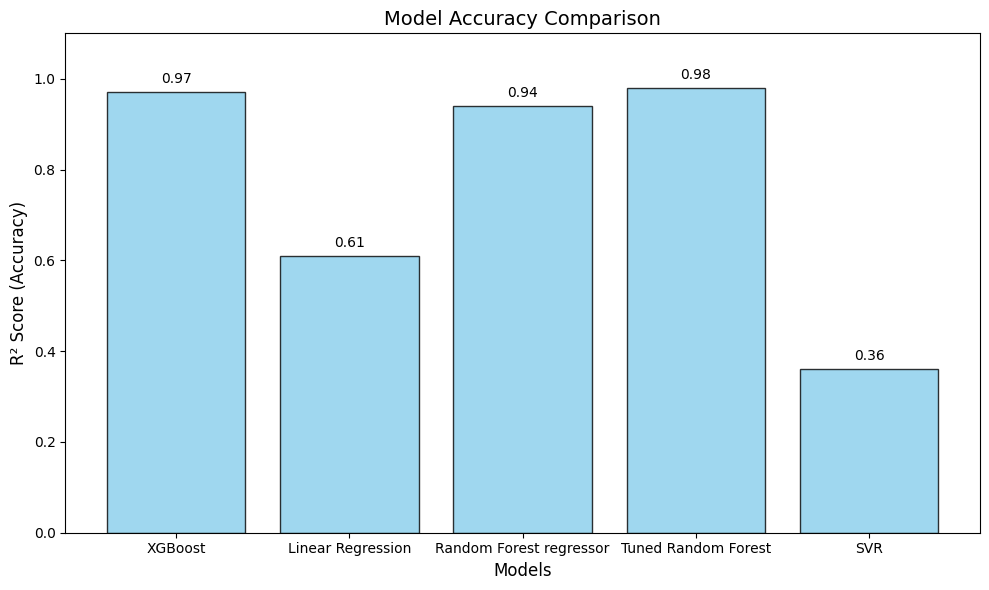

In [42]:
models = ['XGBoost', 'Linear Regression', 'Random Forest regressor', 'Tuned Random Forest', 'SVR']
r2_scores = [0.97, 0.61, 0.94, 0.98, 0.36]

# Bar chart for R² scores
plt.figure(figsize=(10, 6))
bar_positions = np.arange(len(models))
plt.bar(bar_positions, r2_scores, color='skyblue', alpha=0.8, edgecolor='black')

# Add labels and title
plt.xlabel('Models', fontsize=12)
plt.ylabel('R² Score (Accuracy)', fontsize=12)
plt.title('Model Accuracy Comparison', fontsize=14)
plt.xticks(bar_positions, models)
plt.ylim(0, 1.1)  # R² score ranges between 0 and 1

# Show R² scores on top of each bar
for i, score in enumerate(r2_scores):
    plt.text(i, score + 0.02, f"{score:.2f}", ha='center', fontsize=10)

plt.tight_layout()
plt.show()

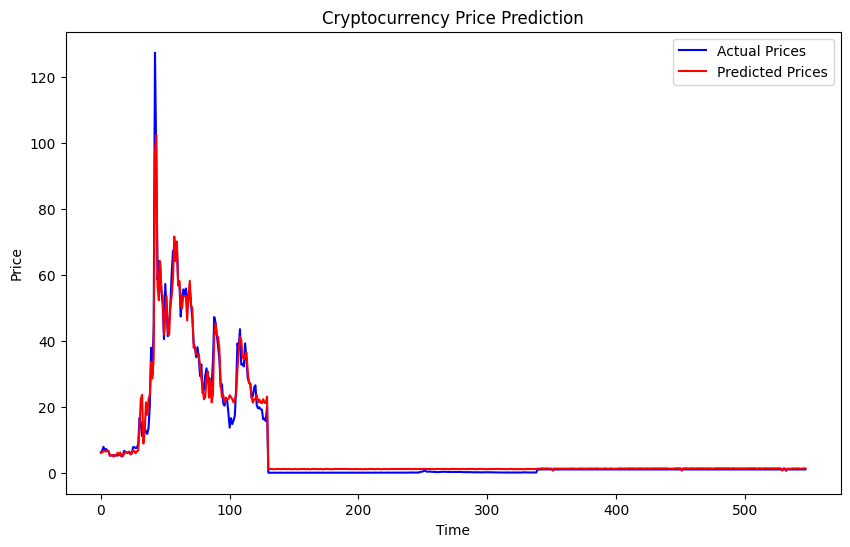

In [45]:
# Visualization
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual Prices', color='blue')
plt.plot(y_pred, label='Predicted Prices', color='red')
plt.title('Cryptocurrency Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()